# 0. Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from itertools import chain
import pickle
from pickle_utils import pickle_load, pickle_dump
from loadGlove import loadGloveModel
import cv2
import os

In [2]:
captions = pd.read_csv("captions.csv", error_bad_lines=False, warn_bad_lines=False)
print("Skipping bad lines - return to this later")
print(captions.shape)
captions.sample(10, random_state=22)

Skipping bad lines - return to this later
(155392, 3)


,image,above_text,below_text
54053,My Precious Gollum,Hello TARA...,HELLO PRECIOUS
67160,Ecstatic Michael Phelps,tHERE'S A POT OF THE STUFF?,i LOVE POT.
49626,katt williams shocked,What,you actually thought you were getting rp?
9727,Okay Guy,TOOK AN ARROW TO THE KNEE,OKAY..
22047,Rich Men Laughing,and then we told them,their health insurance premiums wouldnt go up
150193,kim jong un,they see me rulin',they hatin'
121915,The Olympic Queen,vodka,NaN
132328,Paperclip,it looks like you're having trouble,fapping to this meme
120444,Honey BooBoo,happy birthday,ali boo boo
15655,Not sure if troll,not sure if nicki minaj,or a mutant from mortal combat


In [3]:
# create small subsample
num_labels = 20
random_labels = list(np.random.choice(captions.image.unique(), num_labels))
captions = captions[captions['image'].isin(random_labels)].reset_index(drop=True)

# 1. Load GloVe and save objects for later use

In [4]:
glove_objs = loadGloveModel("glove.txt")

In [5]:
glove_index_dict = glove_objs[0]
glove_embedding_weights = glove_objs[1]

In [6]:
len(glove_index_dict), glove_embedding_weights.shape

(1917494, (1917494, 300))

In [7]:
# pickle_dump(glove_objs, "glove_objs.pkl")
# glove_objs = pickle_load("glove_objs.pkl")

# 2. Clean captions and labels

### a. Remove where there are NaNs in the captions or labels

In [8]:
np.sum(pd.isna(captions))

image           0
above_text     79
below_text    118
dtype: int64

In [9]:
captions.iloc[np.where(pd.isna(captions.image))]

,image,above_text,below_text


In [10]:
captions = captions[pd.notnull(captions.image)]
captions = captions.replace(np.nan, '', regex=True)

In [11]:
np.sum(pd.isna(captions))

image         0
above_text    0
below_text    0
dtype: int64

### b. Everything to lower

In [12]:
captions['image'] = captions['image'].str.lower()
captions['above_text'] = captions['above_text'].str.lower()
captions['below_text'] = captions['below_text'].str.lower()

In [13]:
captions.sample(10, random_state=33)

,image,above_text,below_text
39,bad luck brian,confesses to a crime on death bed,survives
2446,remboraiden,get off,my balls!!
1837,overly manly man,diseases?,you mean workout for my immune system
2241,badvice derpy,watch episode 1,post the spoilers on 4chan
3408,chemistry dog,studies research,p>9000!
2353,remboraiden,hello my name remboraiden,got shitty memes?!?
2300,badvice derpy,playing basketball,totally made it
1588,sad face guy,it's always a sad moment when nicolas cage die...,i really hope he'll never die in the real life
2823,pee wee herman,today's secret words!,suborn perjury
3101,milk was a bad choice,i'm completely miserable,san diego


### c. Remove rows with non-English words

In [14]:
# not implemented
foreign_indicators = ["à","á","â","ä","æ","ã","å","ā","è","é","ê","ë","ē","ė","ę",
                     ]

### d. Remove other bad rows

Combine `above_text` and `below_text` here with appropriate breakpoint tokens. Will re-use this later to tokenize.

In [15]:
breakpoint_captions = "<sos> " + captions.above_text + " <break> " + captions.below_text + " <eos>"

In [16]:
# limit to caption length to under some reasonable upper bound for a meme caption
# for many, the scrape just got messed up and appended many captions into one observation
longinds = []
maxcaplen = 30
howmany = 0
for i, cap in enumerate(breakpoint_captions):
    splitcap = cap.split()
    if len(splitcap) > maxcaplen:
        longinds.append(i)
        howmany += 1
captions = captions.drop(captions.index[longinds]).reset_index(drop=True)
breakpoint_captions = breakpoint_captions.drop(breakpoint_captions.index[longinds])
print("Deleted {} rows".format(howmany))

Deleted 15 rows


### e. Clean miscellaneous bad labels

In [17]:
captions['image'] = captions['image'].str.replace("third",'3rd ')
captions['image'] = captions['image'].str.replace("3rd -world",'3rd world')

# 3. Create word mappings

Structure borrowed from Harvard IACS 2019 ComputeFest [code](https://github.com/Harvard-IACS/2019-computefest/blob/master/Friday/data_preprocess.ipnb.ipynb).

### a. Vocabulary

In [18]:
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [19]:
vocab, vocabcount = get_vocab(list(captions.image) + list(captions.above_text) + list(captions.below_text))


DELETE WORDS HERE BECAUSE I HAVE VOCAB COUNT?

### b. word2idx and idx2word mappings

In [20]:
sos = 1
eos = 0  
br = 2
start_idx = br+1 

word2idx = {word: idx+start_idx for idx, word in enumerate(vocab)}
word2idx['<sos>'] = sos
word2idx['<eos>'] = eos
word2idx['<break>'] = br

idx2word = {ix: word for word, ix in word2idx.items()}

### c. Form embedding matrix

For the words in our observed data, grab the GloVe embeddings. If the word didn't exist in GloVe, initialize it with uniform weights. 

**Maybe I should be deleting rows where no GloVe embeddings exist?**

In [21]:
vocab_size = len(word2idx)
embedding_dim = 300
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

c = 0 # c = number of items w/ GloVe embeddings?
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w))
    if g is None and w.startswith('#'):
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1

### d. Create final data

These next cells create what should be the data we need. This includes right padding tokenzied captions.

In [22]:
# add padding
def rpad(x, maxlen=maxcaplen, eos=eos):
    assert maxlen >= 0
    if maxlen == 0:
        return [eos]
    n = len(x)
    if n > maxlen:
        x = x[-maxlen:]
        n = maxlen
    return x + [eos]*(maxlen-n)

In [23]:
tokenized_captions = [rpad([word2idx[token] for token in cap.split()]) for cap in breakpoint_captions]                  

In [35]:
tokenized_images = [[word2idx[token] for token in cap.split()] for cap in captions.image]   

Sanity check.

In [24]:
# print("IMAGE LABEL: ", captions.image[24])
# print("TOKENIZED IMAGE LABEL: ", tokenized_images[24])
# print("CAPTION: ", captions.above_text[24] + " " + captions.below_text[24])
# print("CAPTION WITH BREAKPOINTS: ", breakpoint_captions[24])
# print("TOKENIZED CAPTION: ", tokenized_captions[24])
# print("CAPTION LENGTH: ", len(tokenized_captions[24]))
# for token in tokenized_captions[24]:
#     print(idx2word[token])

### e. Validate findings

Length: 30, index: 1368 
 <sos> i don't always weaponize hallucinogens  <break> but when i do i dump it in the water supply and use a microwave emitter to get it into the air <eos>


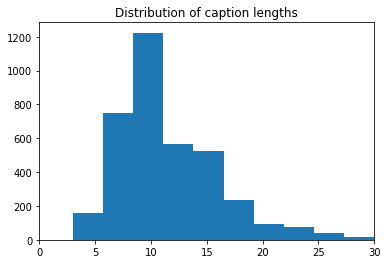

In [25]:
maxlen = 0
longcap = ""
ind = 0
lens = []
for i, cap in enumerate(breakpoint_captions):
    splitcap = cap.split()
    lens.append(len(splitcap))
    if len(splitcap) > maxlen:
        maxlen = len(splitcap)
        longcap = cap
        ind = i
print("Length: {}, index: {} \n {}".format(maxlen, ind, longcap))
plt.hist(lens)
plt.xlim([0, 30])
plt.title("Distribution of caption lengths");

### f. Save

In [26]:
captions_copy = captions.copy()

In [27]:
def strip_junk(x):
    illegal = ["?", "'", " /", "[", "]", ".", "á", " -", "*", "/", "!", 
               "ñ", "í", "(", ")", "$", "\"", "`", ":", ";"]
    end_illegal = [' ', '-']
    impute_chars = ['- ',' ', '_']
    
    for char in end_illegal:
        while x[-1] == char:  # strip off illegal end characters
            x = x[:-1]
        
    
    for char in illegal:
        if char in x:  # strip off overall illegal characters
            x = x.replace(char, "")
        
    for char in impute_chars: # impute certain characters
        x = x.replace(char, "-")
    return x + ".jpg"  

In [28]:
# fill out csv
captions_copy['file_path'] = captions_copy['image'].apply(strip_junk)
captions_copy['full_caption'] = breakpoint_captions
captions_copy['full_padded_caption'] = pd.Series((cap for cap in tokenized_captions))
captions_copy['tokenized_label'] = tokenized_images
captions_copy['image'] = captions_copy['image'].apply(lambda x: x.strip(' '))

In [29]:
out_file = "small_processed_data.pkl"
out_objs = (embedding, idx2word, word2idx, captions_copy)
pickle_dump(out_objs, out_file)

writing total_bytes=18781959...
writing bytes [0, 18781959)... done.


---